<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/Final_Taiwan_kuncheva_cosine_owen_groups_shap_banzhaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


LOADING AND PREPROCESSING TAIWAN CREDIT CARD DEFAULT DATASET
✓ Dataset loaded successfully with xlrd
Dataset shape: (30000, 24)
Target distribution: {0: 23364, 1: 6636}
Default rate: 22.12%
Imbalance ratio: 3.52:1

Categorical columns (9): ['gender', 'education', 'marriage', 'repayment_status_sep', 'repayment_status_aug', 'repayment_status_jul', 'repayment_status_jun', 'repayment_status_may', 'repayment_status_apr']
Numeric columns (14): ['credit_limit', 'age', 'bill_amount_sep', 'bill_amount_aug', 'bill_amount_jul', 'bill_amount_jun', 'bill_amount_may', 'bill_amount_apr', 'payment_amount_sep', 'payment_amount_aug']...

Number of processed features: 82

Class weights: {0: 0.6420133538777607, 1: 2.2603978300180834}

STARTING COMPREHENSIVE EXPERIMENT - TAIWAN DATASET

Building feature graph for Myerson value...
Graph built with 82 nodes and 229 edges

Processing: RF + None
 Fold 1 | RF+None            → AUC: 0.7884
 Fold 2 | RF+None            → AUC: 0.7758
 Fold 3 | RF+None            

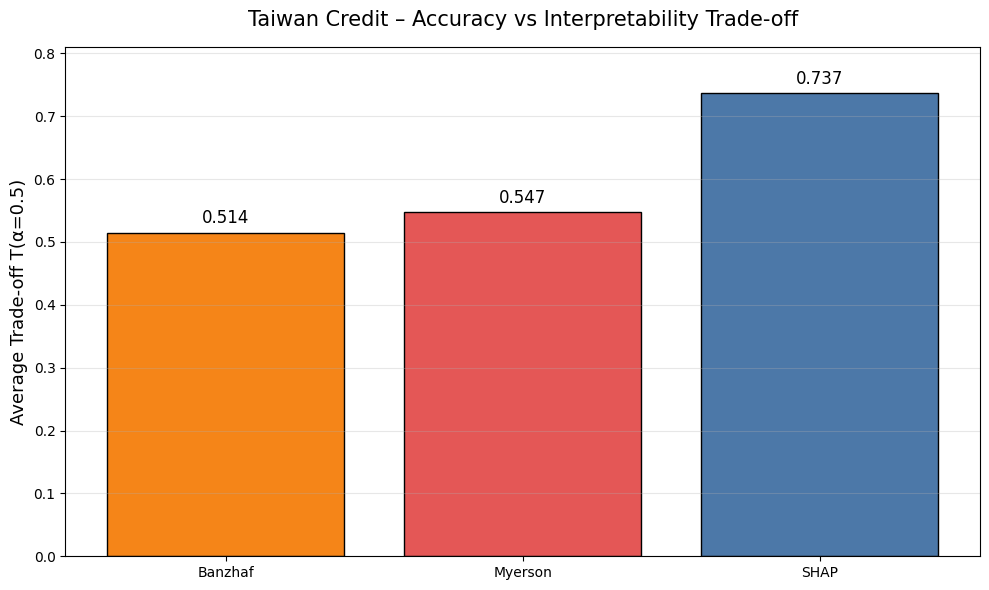

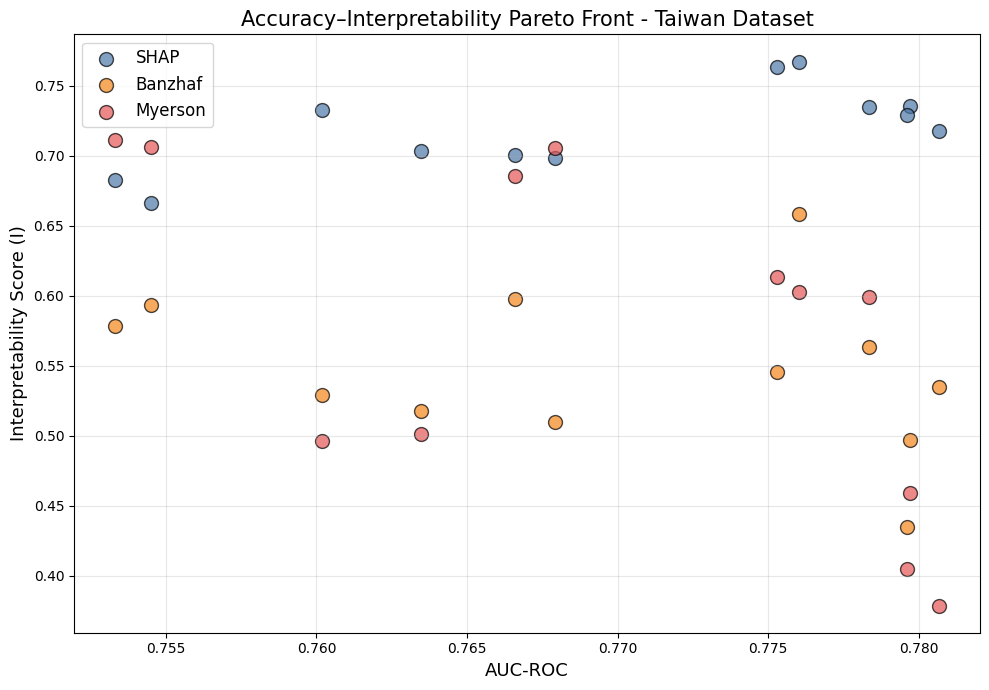

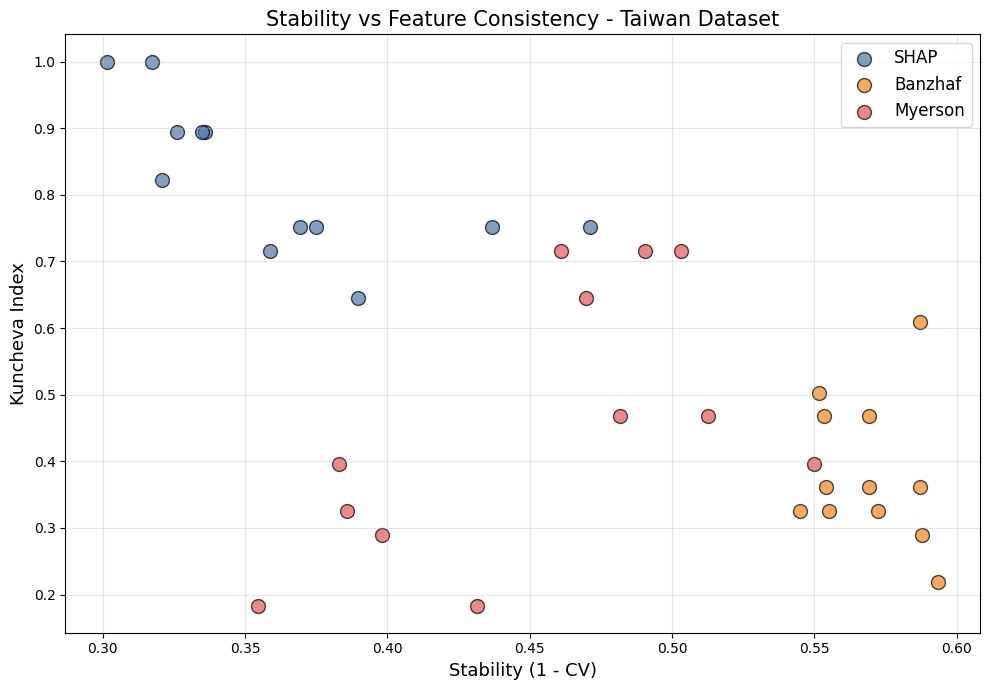


SEPARATE ANALYSIS: OWEN GROUPING STRATEGIES

Owen Grouping Summary:
             AUC  Stability  Kuncheva  Cosine       I       Q  T(α=0.5)
Grouping                                                               
Data      0.7662     0.3326    0.8876  0.8387  0.6863  9.5947    0.4957
Domain    0.7662     0.8444    1.0000  0.9899  0.9448  2.6122    0.7646
Model     0.7662     0.6547    0.0859  0.8338  0.5248  2.3294    0.3277

Spearman Correlation (Q vs I): ρ = 0.1034, p = 0.5483


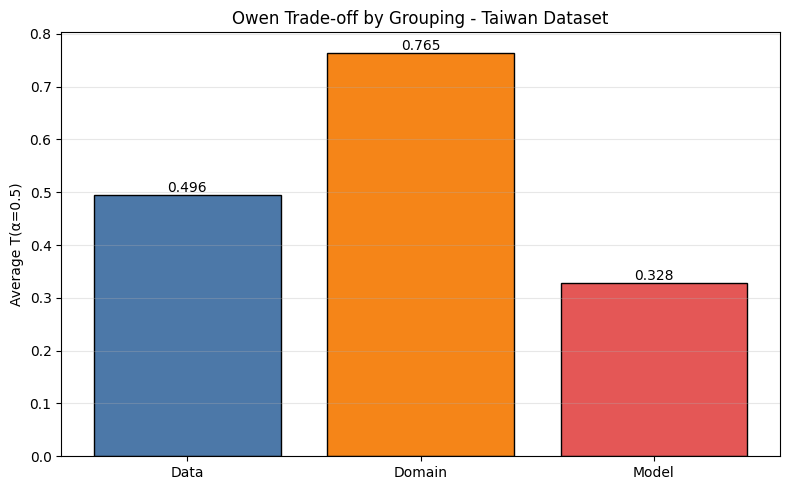

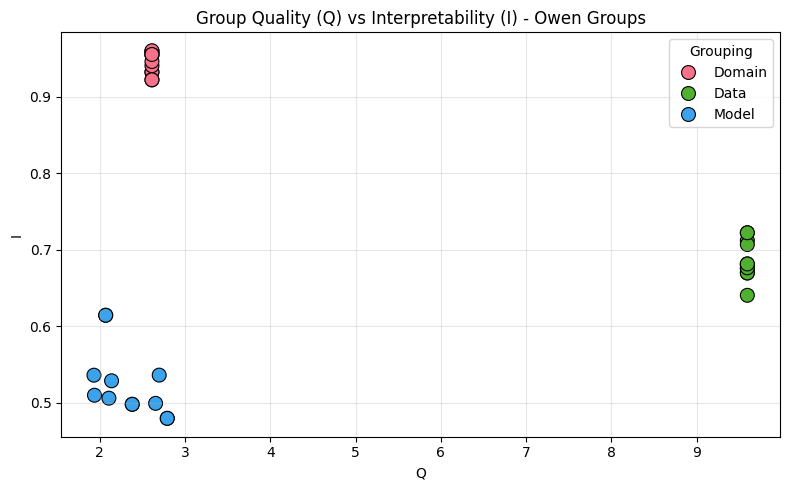

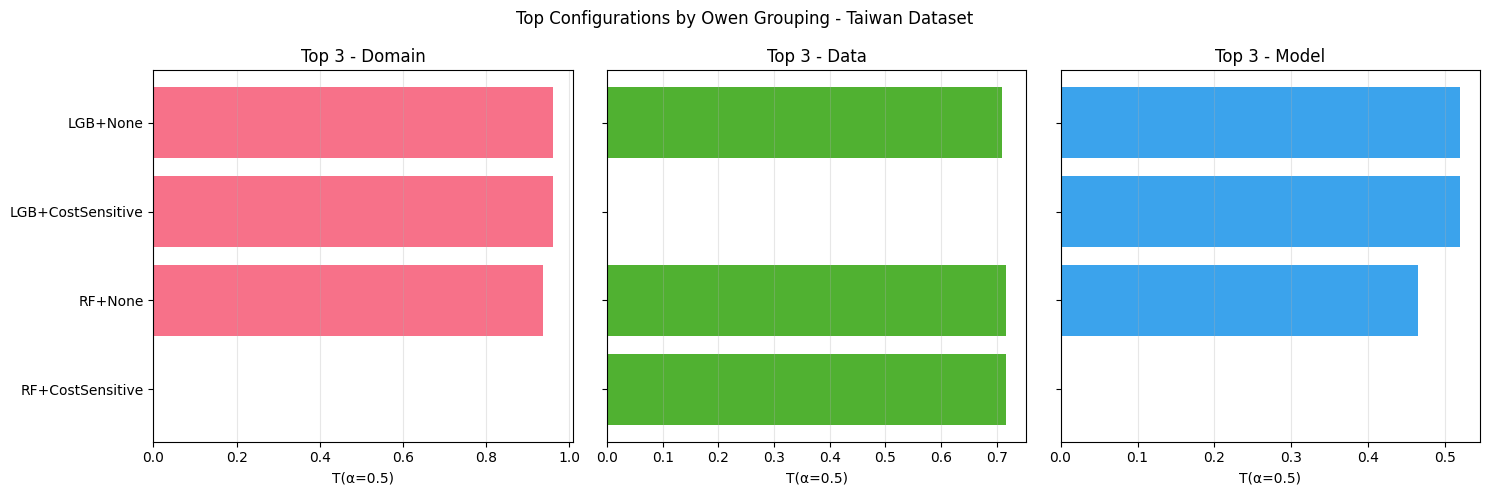


TAIWAN DATASET EXPERIMENT COMPLETE!


In [5]:
# ============================================================
# TAIWAN CREDIT CARD DATASET - COMPLETE GAME THEORY EXPLAINABILITY
# ============================================================

# Install missing libraries if needed
!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs xlrd openpyxl -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD AND PREPROCESS TAIWAN CREDIT CARD DATASET
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING TAIWAN CREDIT CARD DEFAULT DATASET")
print("="*80)

# Load Taiwan Credit Card dataset
# can download from: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
# Or use direct URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

# Load the dataset with explicit engine
try:
    df = pd.read_excel(url, header=1, engine='openpyxl')  # Use openpyxl engine
    print("✓ Dataset loaded successfully with openpyxl")
except:
    try:
        df = pd.read_excel(url, header=1, engine='xlrd')  # Fallback to xlrd
        print("✓ Dataset loaded successfully with xlrd")
    except Exception as e:
        print(f"✗ Failed to load dataset: {e}")
        # Try alternative download method
        import urllib.request
        import os
        print("Attempting alternative download method...")
        urllib.request.urlretrieve(url, 'taiwan_credit_card.xls')
        df = pd.read_excel('taiwan_credit_card.xls', header=1, engine='openpyxl')
        print("✓ Dataset downloaded and loaded successfully")

# Clean up the dataset
df = df.rename(columns={'default payment next month': 'target'})
df = df.drop('ID', axis=1)  # Drop ID column

# Rename columns for better understanding
new_col_names = {
    'LIMIT_BAL': 'credit_limit',
    'SEX': 'gender',
    'EDUCATION': 'education',
    'MARRIAGE': 'marriage',
    'AGE': 'age',
    'PAY_0': 'repayment_status_sep',
    'PAY_2': 'repayment_status_aug',
    'PAY_3': 'repayment_status_jul',
    'PAY_4': 'repayment_status_jun',
    'PAY_5': 'repayment_status_may',
    'PAY_6': 'repayment_status_apr',
    'BILL_AMT1': 'bill_amount_sep',
    'BILL_AMT2': 'bill_amount_aug',
    'BILL_AMT3': 'bill_amount_jul',
    'BILL_AMT4': 'bill_amount_jun',
    'BILL_AMT5': 'bill_amount_may',
    'BILL_AMT6': 'bill_amount_apr',
    'PAY_AMT1': 'payment_amount_sep',
    'PAY_AMT2': 'payment_amount_aug',
    'PAY_AMT3': 'payment_amount_jul',
    'PAY_AMT4': 'payment_amount_jun',
    'PAY_AMT5': 'payment_amount_may',
    'PAY_AMT6': 'payment_amount_apr'
}

df = df.rename(columns=new_col_names)
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
# Education, Marriage, and repayment status columns are categorical
categorical_features = ['gender', 'education', 'marriage'] + \
                      [col for col in X.columns if 'repayment_status' in col]
numeric_features = [col for col in X.columns if col not in categorical_features]

# Convert repayment status columns to categorical (they have values -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8)
for col in categorical_features:
    if 'repayment_status' in col:
        X[col] = X[col].astype(str)

print(f"\nCategorical columns ({len(categorical_features)}): {categorical_features}")
print(f"Numeric columns ({len(numeric_features)}): {numeric_features[:10]}...")  # Show first 10

# Create preprocessing pipeline
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in categorical_features]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                         sparse_output=False, categories=cat_categories), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Fit preprocessor
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]
print(f"\nNumber of processed features: {d}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES (TAIWAN)
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                            eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                             verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

# Compute class weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS
# ============================================================
def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc), n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# Define feature groups for Taiwan dataset (adapted)
feature_groups = {
    'Demographic': ['gender', 'education', 'marriage', 'age'],
    'Financial': ['credit_limit', 'bill_amount_sep', 'bill_amount_aug', 'bill_amount_jul',
                  'bill_amount_jun', 'bill_amount_may', 'bill_amount_apr',
                  'payment_amount_sep', 'payment_amount_aug', 'payment_amount_jul',
                  'payment_amount_jun', 'payment_amount_may', 'payment_amount_apr'],
    'Repayment': ['repayment_status_sep', 'repayment_status_aug', 'repayment_status_jul',
                  'repayment_status_jun', 'repayment_status_may', 'repayment_status_apr']
}

def compute_owen(pipe, X_test, feature_groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps['clf']
    prep = pipe.named_steps['prep']
    X_proc = prep.transform(X_test)
    fnames = prep.get_feature_names_out()
    group_idx = {}
    for g, feats in feature_groups.items():
        indices = []
        for i, name in enumerate(fnames):
            if any(feat in name for feat in feats):
                indices.append(i)
        group_idx[g] = indices
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                gmask = {g: np.random.choice([0,1]) for g in group_idx}
                mask = np.ones(n_feat)
                for g, idxs in group_idx.items():
                    if not gmask[g]:
                        mask[idxs] = 0
                    elif f in idxs:
                        for idx in idxs:
                            if idx != f:
                                mask[idx] = np.random.choice([0,1])
                x_with = x * mask.reshape(1, -1)
                p1 = clf.predict_proba(x_with)[0, 1]
                mask_without = mask.copy()
                mask_without[f] = 0
                x_without = x * mask_without.reshape(1, -1)
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# Myerson
def build_feature_graph(preprocessor, X, threshold=0.25):
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)
    G = nx.Graph()
    d = corr.shape[0]
    G.add_nodes_from(range(d))
    for i in range(d):
        for j in range(i+1, d):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])
    return G, corr

def myerson_value(pipe, X_test, G, alpha=0.5, max_instances=50):
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)
    d = len(shap_mean)
    phi = np.zeros(d)
    for i in range(d):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean
    return np.tile(phi, (min(max_instances, len(X_test)), 1))

# ============================================================
# 4. METRICS (with cosine directional consistency)
# ============================================================
def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    if len(expl_list) < 2:
        return 0.0
    sets = []
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())
    if len(sets) < 2:
        return 0.0
    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)
    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    if len(expl_list) < 2:
        return 0.0
    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []
    for p in range(K):
        for s in range(p + 1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos = 1 - cosine(v_p, v_s)  # Use 1 - cosine distance for similarity
            cos_sims.append(cos)
    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)  # Average cosine similarity

def interpretability_score(cv, kuncheva, cosine, beta=1/3):
    return beta * (1 - cv) + beta * kuncheva + beta * cosine

def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. MAIN EXPERIMENT LOOP (TAIWAN)
# ============================================================
print("\n" + "="*80)
print("STARTING COMPREHENSIVE EXPERIMENT - TAIWAN DATASET")
print("="*80)

# Build feature graph for Myerson
print("\nBuilding feature graph for Myerson value...")
G_myerson, _ = build_feature_graph(preprocessor, X, threshold=0.25)
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

# Setup cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_runs, banzhaf_runs, myerson_runs = [], [], []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f" SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((len(X_sample), n_features)))

            # Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f" Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

            # Myerson
            try:
                my_vals = myerson_value(pipe, X_sample, G_myerson)
                myerson_runs.append(my_vals)
            except Exception as e:
                print(f" Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((len(X_sample), n_features)))

        auc_mean = np.mean(aucs)

        for method, runs in zip(['SHAP', 'Banzhaf', 'Myerson'], [shap_runs, banzhaf_runs, myerson_runs]):
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)
            all_records.append({
                'Model': mname,
                'Sampler': sname,
                'Method': method,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I
            })

# ============================================================
# 6. OWEN GROUPING EXPERIMENT (SEPARATE ANALYSIS FOR TAIWAN)
# ============================================================
print("\n" + "="*80)
print("RUNNING OWEN GROUPING EXPERIMENT - TAIWAN DATASET")
print("="*80)

# Define Taiwan-specific domain groups
def build_domain_groups_taiwan(fnames):
    groups = {
        "Demographic": [],
        "Financial": [],
        "Repayment": []
    }
    for i, name in enumerate(fnames):
        lname = name.lower()
        if any(k in lname for k in ["gender", "education", "marriage", "age"]):
            groups["Demographic"].append(i)
        if any(k in lname for k in ["credit_limit", "bill_amount", "payment_amount"]):
            groups["Financial"].append(i)
        if "repayment_status" in lname:
            groups["Repayment"].append(i)
    return {g: v for g, v in groups.items() if len(v) > 0}

# ---------- Data-driven groups ----------
def build_data_groups(X_proc, n_groups=6):
    try:
        # Clean X_proc
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        # Compute correlation safely
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        # Handle NaN/Inf in correlation
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        # Ensure valid correlation values
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        # Ensure distance matrix is valid
        dist = np.clip(dist, 0.0, 2.0)
        # Check if we have enough features
        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)
        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Warning: Data-driven grouping failed: {e}")
        # Return default groups
        n_features = X_proc.shape[1]
        default_groups = {"Default_Group": list(range(n_features))}
        return default_groups, np.eye(n_features)

# ---------- Model-driven groups ----------
def build_model_groups(shap_vals, n_groups=6):
    try:
        # Clean SHAP values
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        # Handle different dimensions
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()
        # Transpose for correlation if needed
        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T
        # Ensure we have enough samples
        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            default_groups = {"Default_Group": list(range(n_features))}
            return default_groups, np.eye(n_features)
        # Compute correlation safely
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        # Handle NaN/Inf
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)
        # Adjust n_groups if needed
        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)
        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"SHAPGroup_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Warning: Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        default_groups = {"Default_Group": list(range(n_features))}
        return default_groups, np.eye(n_features)

# ---------- Q metric ----------
def compute_Q(groups, dep):
    try:
        d = dep.shape[0]
        group_id = np.full(d, -1)
        for gid, (gname, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d:
                    group_id[f] = gid
        within, across = [], []
        for i in range(d):
            for j in range(i+1, d):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])
        if len(within) == 0 or len(across) == 0:
            return 1.0
        within_mean = np.mean(within)
        across_mean = np.mean(across)
        if across_mean == 0:
            return 1.0 if within_mean == 0 else 10.0
        return float(within_mean / across_mean)
    except:
        return 1.0

# ---------- Owen redistribution ----------
def owen_from_shap(phi, groups):
    d = len(phi)
    out = np.zeros(d)
    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        # Only consider valid indices
        valid_feats = [f for f in feats if f < d]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

owen_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        aucs = []
        dom_runs, data_runs, model_runs = [], [], []
        Q_dom_list, Q_data_list, Q_mod_list = [], [], []
        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                phi = np.mean(shap_vals, axis=0)
            except:
                phi = np.zeros(d)

            X_tr_proc = pipe.named_steps['prep'].transform(X_tr)
            fnames = preprocessor.get_feature_names_out()

            # Domain groups
            dom_groups = build_domain_groups_taiwan(fnames)
            corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
            corr_tr = np.nan_to_num(corr_tr, nan=0.0)
            Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            dom_runs.append(np.tile(owen_from_shap(phi, dom_groups), (len(X_sample), 1)))

            # Data groups
            data_groups, dep_data = build_data_groups(X_tr_proc)
            Q_data_list.append(compute_Q(data_groups, dep_data))
            data_runs.append(np.tile(owen_from_shap(phi, data_groups), (len(X_sample), 1)))

            # Model groups
            bg_sample = X_tr.sample(n=min(100, len(X_tr)), random_state=42)
            shap_bg = get_shap_reliable(pipe, bg_sample)
            mod_groups, dep_mod = build_model_groups(shap_bg)
            Q_mod_list.append(compute_Q(mod_groups, dep_mod))
            model_runs.append(np.tile(owen_from_shap(phi, mod_groups), (len(X_sample), 1)))

        auc_mean = np.mean(aucs)

        for grouping, runs, Q_list in zip(['Domain', 'Data', 'Model'], [dom_runs, data_runs, model_runs], [Q_dom_list, Q_data_list, Q_mod_list]):
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)
            owen_records.append({
                'Model': mname,
                'Sampler': sname,
                'Method': 'Owen',
                'Grouping': grouping,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': np.mean(Q_list)
            })

# ============================================================
# 7. PROCESS AND SAVE RESULTS (TAIWAN)
# ============================================================
if all_records:
    metrics = pd.DataFrame(all_records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\n" + "="*80)
    print("COMPLETE RESULTS - TAIWAN DATASET")
    print("="*80)
    print(metrics.round(4).to_string(index=False))

    metrics.to_csv('taiwan_complete_results.csv', index=False)
    print("\n✓ Results saved to: taiwan_complete_results.csv")

# ============================================================
# 8. VISUALIZATIONS FOR TAIWAN RESULTS
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS FOR TAIWAN RESULTS")
    print("="*80)

    colors = {'SHAP': '#4C78A8', 'Banzhaf': '#F58518', 'Myerson': '#E45756', 'Owen': '#72B7A2'}

    # 1. Average Trade-off by Method
    plt.figure(figsize=(10, 6))
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean()
    bars = plt.bar(method_avg.index, method_avg.values, color=[colors[m] for m in method_avg.index], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("Taiwan Credit – Accuracy vs Interpretability Trade-off", fontsize=15, pad=15)
    plt.ylim(0, method_avg.max() * 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('taiwan_tradeoff_by_method.png', dpi=300)
    plt.show()

    # 2. Pareto Front: AUC vs I
    plt.figure(figsize=(10, 7))
    for method in metrics['Method'].unique():
        sub = metrics[metrics['Method'] == method]
        plt.scatter(sub['AUC'], sub['I'], s=100, label=method, color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("AUC-ROC", fontsize=13)
    plt.ylabel("Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front - Taiwan Dataset", fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('taiwan_pareto_front.png', dpi=300)
    plt.show()

    # 3. Stability vs Kuncheva Scatter
    plt.figure(figsize=(10, 7))
    for method in metrics['Method'].unique():
        sub = metrics[metrics['Method'] == method]
        plt.scatter(sub['Stability'], sub['Kuncheva'], s=100, label=method, color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("Stability (1 - CV)", fontsize=13)
    plt.ylabel("Kuncheva Index", fontsize=13)
    plt.title("Stability vs Feature Consistency - Taiwan Dataset", fontsize=15)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('taiwan_stability_vs_kuncheva.png', dpi=300)
    plt.show()

# ============================================================
# 9. SEPARATE OWEN GROUPING ANALYSIS
# ============================================================
owen_df = pd.DataFrame(owen_records)
if not owen_df.empty:
    owen_df['T(α=0.5)'] = tradeoff_metric(owen_df['AUC'], owen_df['I'])

    print("\n" + "="*80)
    print("SEPARATE ANALYSIS: OWEN GROUPING STRATEGIES")
    print("="*80)

    # Summary by grouping
    grouping_summary = owen_df.groupby('Grouping').agg({
        'AUC': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'I': 'mean',
        'Q': 'mean',
        'T(α=0.5)': 'mean'
    }).round(4)
    print("\nOwen Grouping Summary:")
    print(grouping_summary)

    # Correlation between Q and I
    from scipy.stats import spearmanr
    rho, p = spearmanr(owen_df['Q'], owen_df['I'])
    print(f"\nSpearman Correlation (Q vs I): ρ = {rho:.4f}, p = {p:.4f}")

    # Visualizations for Owen Groups
    # 1. Trade-off by Grouping
    plt.figure(figsize=(8, 5))
    bars = plt.bar(grouping_summary.index, grouping_summary['T(α=0.5)'], color=['#4C78A8', '#F58518', '#E45756'], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f')
    plt.ylabel("Average T(α=0.5)")
    plt.title("Owen Trade-off by Grouping - Taiwan Dataset")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('taiwan_owen_tradeoff_grouping.png', dpi=300)
    plt.show()

    # 2. Q vs I Scatter
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=owen_df, x='Q', y='I', hue='Grouping', palette='husl', s=100, edgecolor='black')
    plt.title("Group Quality (Q) vs Interpretability (I) - Owen Groups")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('taiwan_owen_q_vs_i.png', dpi=300)
    plt.show()

    # 3. Top Configurations per Grouping
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for idx, grouping in enumerate(owen_df['Grouping'].unique()):
        sub = owen_df[owen_df['Grouping'] == grouping]
        top = sub.nlargest(3, 'T(α=0.5)')
        labels = [f"{row['Model']}+{row['Sampler']}" for _, row in top.iterrows()]
        axes[idx].barh(labels, top['T(α=0.5)'], color=sns.color_palette("husl", 3)[idx])
        axes[idx].set_title(f"Top 3 - {grouping}")
        axes[idx].set_xlabel("T(α=0.5)")
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)
    plt.suptitle("Top Configurations by Owen Grouping - Taiwan Dataset")
    plt.tight_layout()
    plt.savefig('taiwan_owen_top_configs.png', dpi=300)
    plt.show()

print("\n" + "="*80)
print("TAIWAN DATASET EXPERIMENT COMPLETE!")
print("="*80)

In [6]:
# ============================================================
# COMPREHENSIVE STATISTICAL VALIDATION SUITE - TAIWAN DATASET
# ============================================================

print("\n" + "="*80)
print("COMPREHENSIVE STATISTICAL VALIDATION SUITE - TAIWAN DATASET")
print("="*80)

import scikit_posthocs as sp
from scipy.stats import (friedmanchisquare, wilcoxon, levene,
                         shapiro, spearmanr, kruskal, mannwhitneyu)
import numpy as np

# ------------------------------------------------------------
# 1. FRIEDMAN TESTS (For Overall Methods Comparison)
# ------------------------------------------------------------
print("\n" + "="*80)
print("1. FRIEDMAN TESTS - Overall Method Comparison")
print("="*80)

# Prepare data for Friedman test (non-parametric repeated measures ANOVA)
# We need to pivot data so each row is a unique configuration (Model+Sampler)
# and columns are different methods

for metric in ['AUC', 'I', 'T(α=0.5)']:
    print(f"\nFriedman Test for {metric}:")

    # Pivot table: rows = configurations, columns = methods
    pivoted = metrics.pivot_table(
        values=metric,
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )

    # Drop methods with missing values
    pivoted = pivoted.dropna(axis=1, how='any')

    if pivoted.shape[1] >= 3:  # Need at least 3 methods for Friedman
        data_matrix = pivoted.values
        methods_list = list(pivoted.columns)

        # Perform Friedman test
        stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])

        print(f"  Methods compared: {methods_list}")
        print(f"  Friedman χ² = {stat:.4f}, p = {p_value:.6f}")

        if p_value < 0.05:
            print("  ✓ SIGNIFICANT differences between methods")

            # Post-hoc Nemenyi test
            print(f"\n  Nemenyi Post-Hoc Test for {metric}:")
            nemenyi_results = sp.posthoc_nemenyi_friedman(data_matrix)
            nemenyi_df = pd.DataFrame(nemenyi_results,
                                     index=methods_list,
                                     columns=methods_list)

            # Find significant pairs
            significant_pairs = []
            for i in range(len(methods_list)):
                for j in range(i+1, len(methods_list)):
                    if nemenyi_df.iloc[i, j] < 0.05:
                        significant_pairs.append((methods_list[i], methods_list[j], nemenyi_df.iloc[i, j]))

            if significant_pairs:
                print("  Significant pairwise differences (p < 0.05):")
                for method1, method2, p_val in significant_pairs:
                    print(f"    {method1} vs {method2}: p = {p_val:.4f}")
            else:
                print("  No significant pairwise differences after multiple comparison adjustment")
        else:
            print("  ✗ No significant differences between methods")
    else:
        print(f"  Insufficient complete data for Friedman test (need ≥3 methods with complete data)")

# ------------------------------------------------------------
# 2. WILCOXON SIGNED-RANK TESTS (Pairwise)
# ------------------------------------------------------------
print("\n" + "="*80)
print("2. WILCOXON SIGNED-RANK TESTS - Pairwise Comparisons")
print("="*80)

methods = ['SHAP', 'Banzhaf', 'Myerson', 'Owen']

for metric in ['T(α=0.5)', 'AUC', 'I']:
    print(f"\n{metric} - Wilcoxon Signed-Rank Tests:")

    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1 = methods[i]
            method2 = methods[j]

            # Get data for both methods
            data1 = metrics[metrics['Method'] == method1][metric].values
            data2 = metrics[metrics['Method'] == method2][metric].values

            if len(data1) > 1 and len(data2) > 1 and len(data1) == len(data2):
                # Wilcoxon signed-rank test (paired)
                stat, p_value = wilcoxon(data1, data2)
                mean1, mean2 = np.mean(data1), np.mean(data2)

                sig = "✓" if p_value < 0.05 else "✗"
                direction = f"{method1}>{method2}" if mean1 > mean2 else f"{method2}>{method1}"
                print(f"  {method1} vs {method2}: W={stat:.2f}, p={p_value:.4f} "
                      f"(means: {mean1:.3f} vs {mean2:.3f}) {sig} {direction}")
            else:
                print(f"  {method1} vs {method2}: Incomplete paired data")

# ------------------------------------------------------------
# 3. LEVENE'S TESTS (Equal Variances)
# ------------------------------------------------------------
print("\n" + "="*80)
print("3. LEVENE'S TESTS FOR EQUAL VARIANCES")
print("="*80)

for metric in ['AUC', 'I', 'T(α=0.5)']:
    print(f"\n{metric} - Levene's Test:")

    groups = []
    group_labels = []

    for method in methods:
        data = metrics[metrics['Method'] == method][metric].values
        if len(data) >= 3:  # Need at least 3 observations
            groups.append(data)
            group_labels.append(method)

    if len(groups) >= 2:
        stat, p_value = levene(*groups)
        print(f"  Groups: {group_labels}")
        print(f"  Levene's W = {stat:.4f}, p = {p_value:.4f}")

        if p_value > 0.05:
            print("  ✓ Equal variances across methods (homoscedasticity)")
        else:
            print("  ✗ Unequal variances across methods (heteroscedasticity)")
    else:
        print(f"  Insufficient data for Levene's test")

# ------------------------------------------------------------
# 4. SPEARMAN CORRELATION (AUC vs I)
# ------------------------------------------------------------
print("\n" + "="*80)
print("4. SPEARMAN CORRELATION: AUC vs INTERPRETABILITY")
print("="*80)

# Overall correlation
rho, p_value = spearmanr(metrics['AUC'], metrics['I'])
print(f"\nOverall AUC vs I:")
print(f"  Spearman ρ = {rho:.4f}, p = {p_value:.6f}")

if p_value < 0.05:
    if rho > 0:
        print(f"  ✓ SIGNIFICANT positive correlation: Higher AUC ↔ Higher Interpretability")
        print(f"  Strength: {'Weak' if abs(rho) < 0.3 else 'Moderate' if abs(rho) < 0.7 else 'Strong'}")
    else:
        print(f"  ✓ SIGNIFICANT negative correlation: Higher AUC ↔ Lower Interpretability")
        print(f"  Strength: {'Weak' if abs(rho) < 0.3 else 'Moderate' if abs(rho) < 0.7 else 'Strong'}")
else:
    print(f"  ✗ No significant correlation between AUC and Interpretability")

# Correlation by Method
print("\nCorrelation by Method:")
for method in methods:
    subset = metrics[metrics['Method'] == method]
    if len(subset) >= 3:
        rho, p_value = spearmanr(subset['AUC'], subset['I'])
        sig = "✓" if p_value < 0.05 else "✗"
        direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
        strength = "Weak" if abs(rho) < 0.3 else "Moderate" if abs(rho) < 0.7 else "Strong"
        print(f"  {method}: ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

# ------------------------------------------------------------
# 5. CLIFF'S DELTA EFFECT SIZES
# ------------------------------------------------------------
print("\n" + "="*80)
print("5. CLIFF'S DELTA EFFECT SIZES")
print("="*80)

def cliffs_delta(x, y):
    """Calculate Cliff's delta effect size"""
    n_x, n_y = len(x), len(y)
    greater = sum(1 for i in x for j in y if i > j)
    less = sum(1 for i in x for j in y if i < j)
    delta = (greater - less) / (n_x * n_y)
    return delta

def interpret_delta(delta):
    """Interpret Cliff's delta magnitude"""
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        return "negligible"
    elif abs_delta < 0.33:
        return "small"
    elif abs_delta < 0.474:
        return "medium"
    else:
        return "large"

for metric in ['T(α=0.5)', 'AUC', 'I']:
    print(f"\n{metric} - Cliff's Delta Effect Sizes:")

    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1 = methods[i]
            method2 = methods[j]

            data1 = metrics[metrics['Method'] == method1][metric].values
            data2 = metrics[metrics['Method'] == method2][metric].values

            if len(data1) > 1 and len(data2) > 1:
                delta = cliffs_delta(data1, data2)
                magnitude = interpret_delta(delta)
                direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"

                print(f"  {method1} vs {method2}: δ = {delta:.4f} ({magnitude}, {direction})")

# ------------------------------------------------------------
# 6. SHAPIRO-WILK NORMALITY TESTS
# ------------------------------------------------------------
print("\n" + "="*80)
print("6. SHAPIRO-WILK NORMALITY TESTS")
print("="*80)

for metric in ['AUC', 'I', 'T(α=0.5)']:
    print(f"\n{metric} - Shapiro-Wilk Normality Tests:")

    for method in methods:
        data = metrics[metrics['Method'] == method][metric].values

        if len(data) >= 3 and len(data) <= 5000:  # Shapiro-Wilk valid for 3-5000 samples
            stat, p_value = shapiro(data)
            normal = "Normal" if p_value > 0.05 else "Non-normal"
            print(f"  {method}: W = {stat:.4f}, p = {p_value:.4f} ({normal})")
        else:
            print(f"  {method}: Insufficient data for Shapiro-Wilk")

# ------------------------------------------------------------
# 7. KRUSKAL-WALLIS TEST FOR OWEN GROUPING STRATEGIES
# ------------------------------------------------------------
print("\n" + "="*80)
print("7. KRUSKAL-WALLIS TEST - Owen Grouping Strategies")
print("="*80)

if 'owen_df' in locals() and not owen_df.empty:
    # Filter only Owen rows from main metrics
    owen_metrics = metrics[metrics['Method'] == 'Owen']

    if 'Grouping' in owen_metrics.columns and len(owen_metrics['Grouping'].unique()) >= 2:
        for metric in ['T(α=0.5)', 'I', 'AUC']:
            print(f"\n{metric} - Owen Grouping Comparison:")

            # Get data for each grouping
            groups_data = []
            group_labels = []

            for grouping in owen_metrics['Grouping'].unique():
                data = owen_metrics[owen_metrics['Grouping'] == grouping][metric].values
                if len(data) > 0:
                    groups_data.append(data)
                    group_labels.append(grouping)

            if len(groups_data) >= 2:
                # Perform Kruskal-Wallis test (non-parametric ANOVA)
                stat, p_value = kruskal(*groups_data)

                print(f"  Groups: {group_labels}")
                print(f"  Kruskal-Wallis H = {stat:.4f}, p = {p_value:.4f}")

                if p_value < 0.05:
                    print("  ✓ SIGNIFICANT differences between Owen grouping strategies")

                    # Post-hoc Dunn's test
                    print(f"  Post-hoc Dunn's Test for {metric}:")

                    # Prepare data for Dunn's test
                    from scikit_posthocs import posthoc_dunn

                    # Create a dataframe for Dunn's test
                    dunn_data = []
                    for idx, grouping in enumerate(group_labels):
                        for value in groups_data[idx]:
                            dunn_data.append({'Group': grouping, 'Value': value})

                    dunn_df = pd.DataFrame(dunn_data)

                    # Perform Dunn's test
                    dunn_results = posthoc_dunn(dunn_df, val_col='Value', group_col='Group')

                    # Find significant pairs
                    significant_pairs = []
                    for i in range(len(group_labels)):
                        for j in range(i+1, len(group_labels)):
                            p_val = dunn_results.iloc[i, j]
                            if p_val < 0.05:
                                significant_pairs.append((group_labels[i], group_labels[j], p_val))

                    if significant_pairs:
                        print("  Significant pairwise differences (p < 0.05):")
                        for group1, group2, p_val in significant_pairs:
                            print(f"    {group1} vs {group2}: p = {p_val:.4f}")
                    else:
                        print("  No significant pairwise differences after multiple comparison adjustment")

                    # Calculate effect sizes between groupings
                    print(f"  Cliff's Delta Effect Sizes for {metric}:")
                    for i in range(len(group_labels)):
                        for j in range(i+1, len(group_labels)):
                            group1 = group_labels[i]
                            group2 = group_labels[j]

                            data1 = owen_metrics[owen_metrics['Grouping'] == group1][metric].values
                            data2 = owen_metrics[owen_metrics['Grouping'] == group2][metric].values

                            if len(data1) > 1 and len(data2) > 1:
                                delta = cliffs_delta(data1, data2)
                                magnitude = interpret_delta(delta)
                                direction = f"{group1}>{group2}" if delta > 0 else f"{group2}>{group1}"
                                print(f"    {group1} vs {group2}: δ = {delta:.4f} ({magnitude}, {direction})")
                else:
                    print("  ✗ No significant differences between Owen grouping strategies")

                # Summary statistics for each grouping
                print(f"  Summary Statistics for {metric}:")
                for grouping in group_labels:
                    data = owen_metrics[owen_metrics['Grouping'] == grouping][metric].values
                    if len(data) > 0:
                        mean_val = np.mean(data)
                        std_val = np.std(data)
                        print(f"    {grouping}: Mean = {mean_val:.4f}, SD = {std_val:.4f}, N = {len(data)}")
            else:
                print(f"  Insufficient data for Kruskal-Wallis test")
    else:
        print("No grouping information available for Owen method")
else:
    print("Owen dataframe not available for analysis")

# ------------------------------------------------------------
# 8. MANN-WHITNEY U TESTS (Independent Samples)
# ------------------------------------------------------------
print("\n" + "="*80)
print("8. MANN-WHITNEY U TESTS - Independent Comparisons")
print("="*80)

# Compare specific pairs of interest
pairs_of_interest = [
    ('SHAP', 'Banzhaf'),
    ('SHAP', 'Myerson'),
    ('SHAP', 'Owen'),
    ('Banzhaf', 'Myerson'),
    ('Banzhaf', 'Owen'),
    ('Myerson', 'Owen')
]

for metric in ['T(α=0.5)', 'AUC', 'I']:
    print(f"\n{metric} - Mann-Whitney U Tests:")

    for method1, method2 in pairs_of_interest:
        data1 = metrics[metrics['Method'] == method1][metric].values
        data2 = metrics[metrics['Method'] == method2][metric].values

        if len(data1) > 1 and len(data2) > 1:
            stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
            mean1, mean2 = np.mean(data1), np.mean(data2)

            sig = "✓" if p_value < 0.05 else "✗"
            direction = f"{method1}>{method2}" if mean1 > mean2 else f"{method2}>{method1}"

            # Calculate effect size (Cliff's delta)
            delta = cliffs_delta(data1, data2)
            magnitude = interpret_delta(delta)

            print(f"  {method1} vs {method2}: U = {stat:.2f}, p = {p_value:.4f} "
                  f"(means: {mean1:.3f} vs {mean2:.3f}) {sig} {direction}")
            print(f"    Effect size: δ = {delta:.4f} ({magnitude})")

# ------------------------------------------------------------
# 9. SUMMARY STATISTICS TABLE
# ------------------------------------------------------------
print("\n" + "="*80)
print("9. SUMMARY STATISTICS BY METHOD")
print("="*80)

# Create comprehensive summary table
summary_stats = metrics.groupby('Method').agg({
    'AUC': ['mean', 'std', 'min', 'max', 'count'],
    'I': ['mean', 'std', 'min', 'max'],
    'T(α=0.5)': ['mean', 'std', 'min', 'max']
}).round(4)

print("\nPerformance Summary (mean ± standard deviation):")
print(summary_stats.to_string())

# Owen grouping specific summary (if available)
if 'owen_df' in locals() and not owen_df.empty:
    print("\n" + "="*80)
    print("OWEN GROUPING STRATEGIES - DETAILED ANALYSIS")
    print("="*80)

    owen_summary = owen_df.groupby('Grouping').agg({
        'AUC': ['mean', 'std'],
        'I': ['mean', 'std'],
        'Q': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std', 'count']
    }).round(4)

    print("\nOwen Grouping Performance:")
    print(owen_summary.to_string())

    # Correlation between Q and other metrics
    print("\nCorrelations with Group Quality (Q):")
    for metric in ['I', 'T(α=0.5)', 'AUC']:
        rho, p_value = spearmanr(owen_df['Q'], owen_df[metric])
        sig = "✓" if p_value < 0.05 else "✗"
        direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
        strength = "Weak" if abs(rho) < 0.3 else "Moderate" if abs(rho) < 0.7 else "Strong"
        print(f"  Q vs {metric}: ρ = {rho:.4f}, p = {p_value:.4f} {sig} {direction} {strength}")

# ------------------------------------------------------------
# 10. INTERPRETATION GUIDE
# ------------------------------------------------------------
print("\n" + "="*80)
print("10. STATISTICAL INTERPRETATION GUIDE")
print("="*80)

print("""
Interpretation Guidelines:
────────────────────────────────────────────────────
• Friedman p < 0.05 → Significant differences between explanation methods
• Wilcoxon/Mann-Whitney p < 0.05 → Significant difference between two methods
• Levene p > 0.05 → Equal variances (homoscedasticity)
• Shapiro-Wilk p > 0.05 → Data follows normal distribution
• Spearman |ρ| > 0.7 → Strong correlation, 0.3-0.7 → Moderate, <0.3 → Weak
• Cliff's Delta: |δ| < 0.147 negligible, <0.33 small, <0.474 medium, ≥0.474 large
• Kruskal-Wallis p < 0.05 → Significant differences between Owen grouping strategies

Effect Size Interpretation:
────────────────────────────────────────────────────
• Small effect (δ ~ 0.15): May not be practically significant
• Medium effect (δ ~ 0.33): Noticeable difference
• Large effect (δ > 0.47): Substantial, practically important difference

Statistical Power Considerations:
────────────────────────────────────────────────────
• Small sample sizes may reduce power to detect true differences
• Multiple comparisons increase Type I error risk
• Consider effect sizes alongside p-values for practical significance
""")

print("\n" + "="*80)
print("STATISTICAL VALIDATION COMPLETE - TAIWAN DATASET")
print("="*80)


COMPREHENSIVE STATISTICAL VALIDATION SUITE - TAIWAN DATASET

1. FRIEDMAN TESTS - Overall Method Comparison

Friedman Test for AUC:
  Methods compared: ['Banzhaf', 'Myerson', 'SHAP']
  Friedman χ² = nan, p = nan
  ✗ No significant differences between methods

Friedman Test for I:
  Methods compared: ['Banzhaf', 'Myerson', 'SHAP']
  Friedman χ² = 10.5000, p = 0.005248
  ✓ SIGNIFICANT differences between methods

  Nemenyi Post-Hoc Test for I:
  No significant pairwise differences after multiple comparison adjustment

Friedman Test for T(α=0.5):
  Methods compared: ['Banzhaf', 'Myerson', 'SHAP']
  Friedman χ² = 10.5000, p = 0.005248
  ✓ SIGNIFICANT differences between methods

  Nemenyi Post-Hoc Test for T(α=0.5):
  No significant pairwise differences after multiple comparison adjustment

2. WILCOXON SIGNED-RANK TESTS - Pairwise Comparisons

T(α=0.5) - Wilcoxon Signed-Rank Tests:
  SHAP vs Banzhaf: W=0.00, p=0.0005 (means: 0.737 vs 0.514) ✓ SHAP>Banzhaf
  SHAP vs Myerson: W=8.00, p=0.012


COMPREHENSIVE STATISTICAL VALIDATION - TAIWAN DATASET
Loading and preparing data...
✓ Main metrics loaded: 36 records
✓ Combined data: 72 records (including Owen)

1. FRIEDMAN TESTS - All Methods Comparison

AUC:
  Insufficient complete data (need ≥3 methods with complete data)

I:
  Insufficient complete data (need ≥3 methods with complete data)

T(α=0.5):
  Insufficient complete data (need ≥3 methods with complete data)

2. WILCOXON SIGNED-RANK TESTS - Pairwise Comparisons

T(α=0.5):
  SHAP vs Banzhaf: W=0.00, p=0.0039 (means: 0.707 vs 0.513) ✓ SHAP>Banzhaf
  SHAP vs Myerson: W=8.00, p=0.0977 (means: 0.707 vs 0.569) ✗ SHAP>Myerson
  SHAP vs Owen: W=0.00, p=0.0039 (means: 0.707 vs 0.494) ✓ SHAP>Owen
  Banzhaf vs Myerson: W=12.00, p=0.2500 (means: 0.513 vs 0.569) ✗ Myerson>Banzhaf
  Banzhaf vs Owen: W=19.00, p=0.7344 (means: 0.513 vs 0.494) ✗ Banzhaf>Owen
  Myerson vs Owen: W=15.00, p=0.4258 (means: 0.569 vs 0.494) ✗ Myerson>Owen

AUC:
  SHAP vs Banzhaf: W=0.00, p=1.0000 (means: 0.768

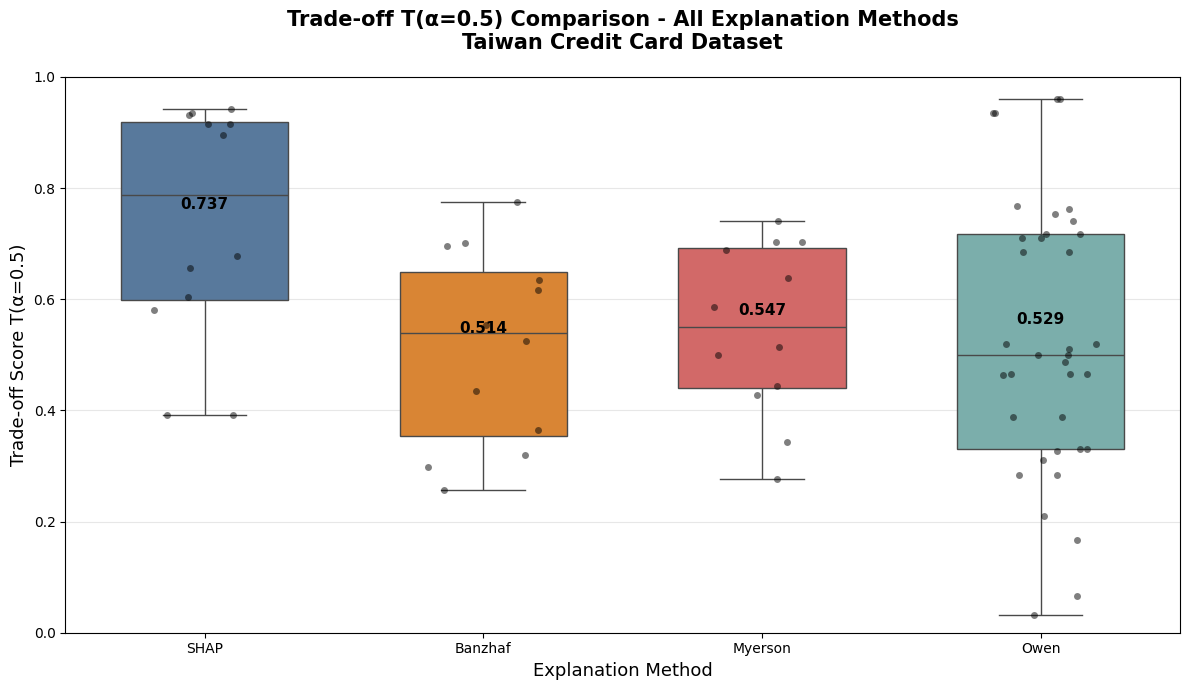

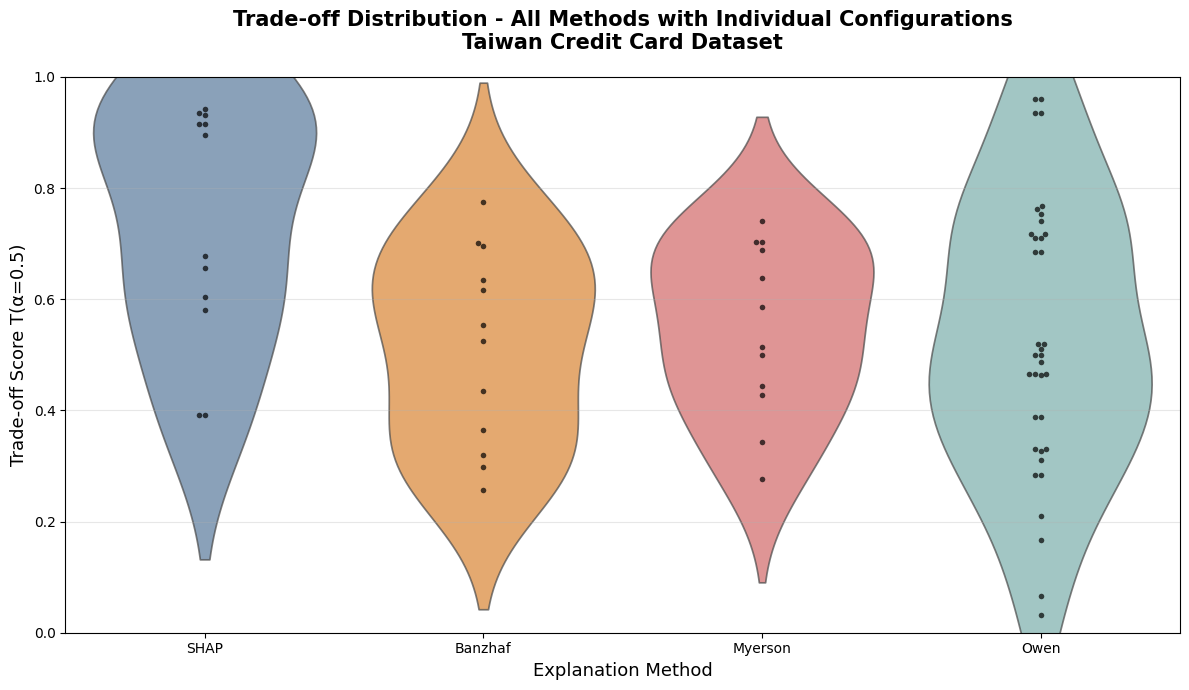

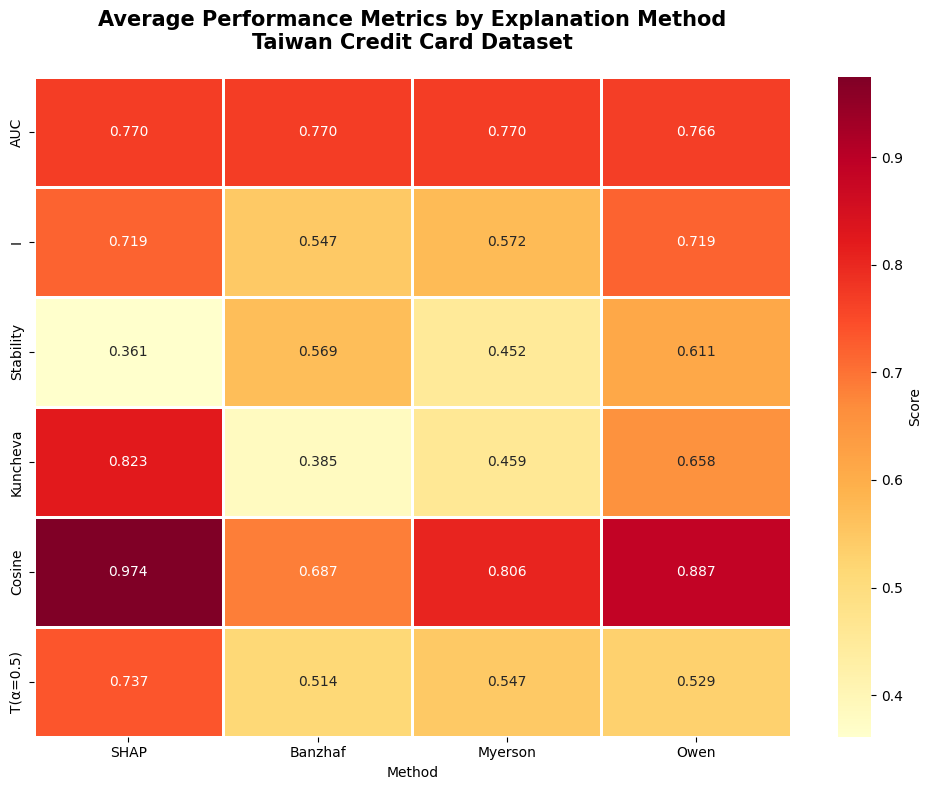

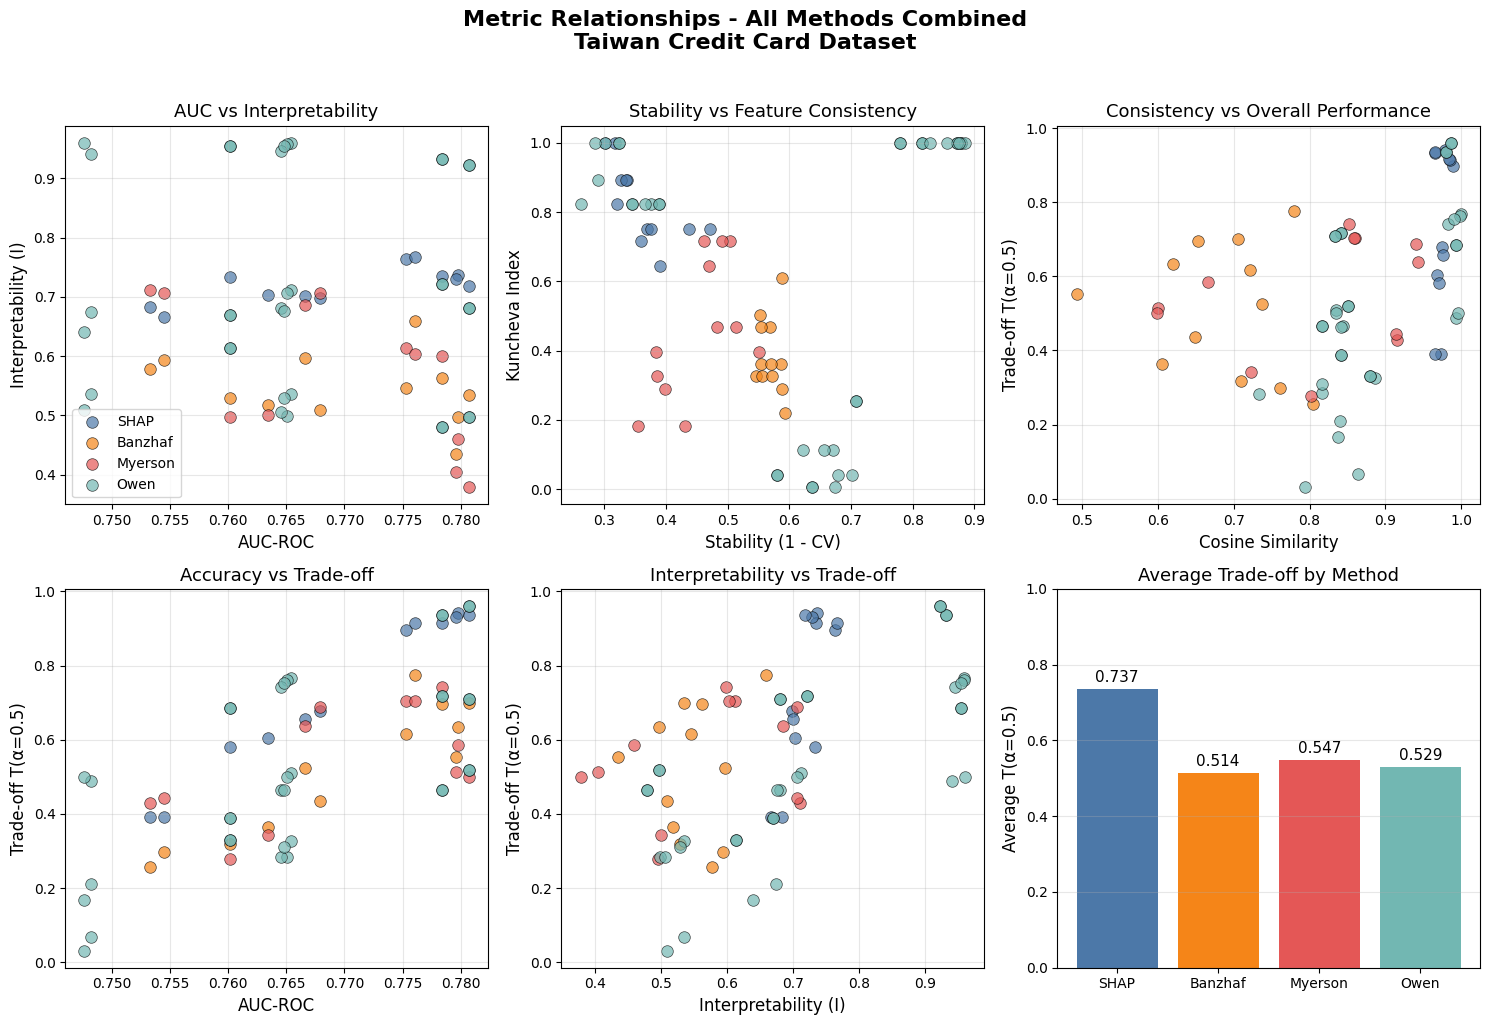


8. OWEN GROUPING STRATEGIES ANALYSIS

T(α=0.5) - Owen Grouping Comparison:
  Groups: ['Domain', 'Data', 'Model']
  Kruskal-Wallis H = 18.8867, p = 0.0001
  ✓ SIGNIFICANT differences between Owen grouping strategies
  Cliff's Delta Effect Sizes:
    Domain vs Data: δ = 0.7222 (large, Domain>Data)
    Domain vs Model: δ = 0.9444 (large, Domain>Model)
    Data vs Model: δ = 0.4722 (medium, Data>Model)
  Summary Statistics:
    Domain: Mean = 0.7646, SD = 0.1570, N = 12
    Data: Mean = 0.4957, SD = 0.1836, N = 12
    Model: Mean = 0.3277, SD = 0.1503, N = 12

I - Owen Grouping Comparison:
  Groups: ['Domain', 'Data', 'Model']
  Kruskal-Wallis H = 31.1712, p = 0.0000
  ✓ SIGNIFICANT differences between Owen grouping strategies
  Cliff's Delta Effect Sizes:
    Domain vs Data: δ = 1.0000 (large, Domain>Data)
    Domain vs Model: δ = 1.0000 (large, Domain>Model)
    Data vs Model: δ = 1.0000 (large, Data>Model)
  Summary Statistics:
    Domain: Mean = 0.9448, SD = 0.0139, N = 12
    Data: M

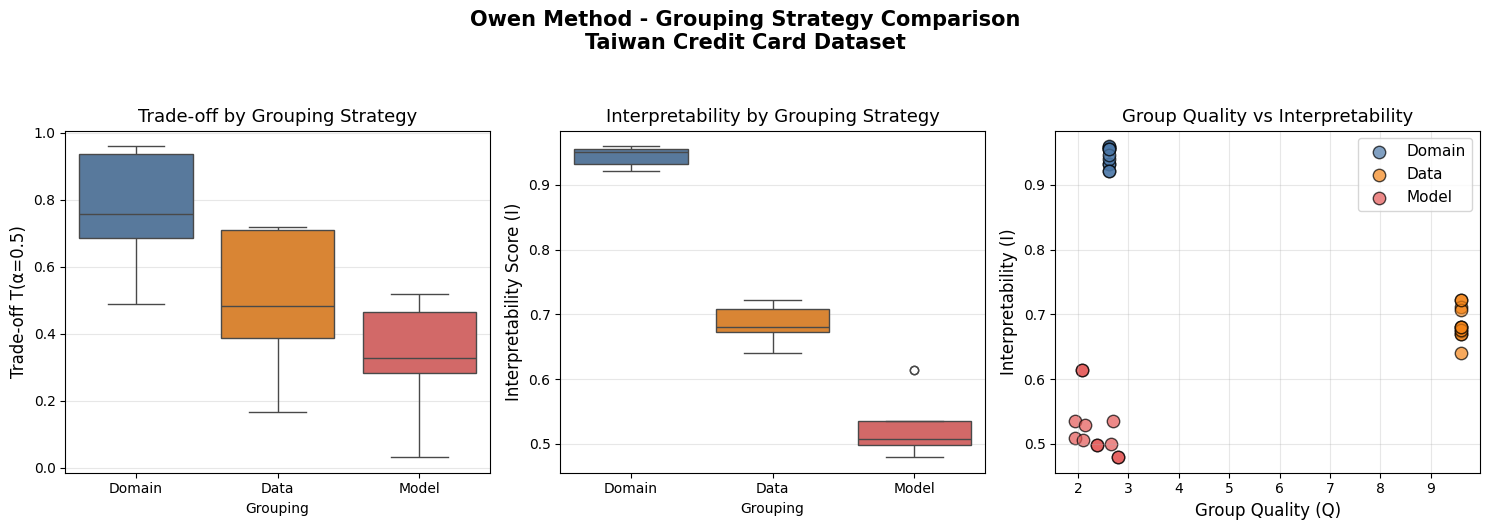


9. FINAL SUMMARY STATISTICS

Average Performance by Method:
            AUC                     I         T(α=0.5)                        
           mean     std count    mean     std     mean     std     min     max
Method                                                                        
Banzhaf  0.7696  0.0100    12  0.5467  0.0574   0.5144  0.1763  0.2567  0.7753
Myerson  0.7696  0.0100    12  0.5722  0.1208   0.5472  0.1534  0.2774  0.7416
Owen     0.7662  0.0112    36  0.7186  0.1780   0.5293  0.2471  0.0314  0.9604
SHAP     0.7696  0.0100    12  0.7195  0.0304   0.7367  0.2130  0.3912  0.9421

Best Performing Method by Metric:
  AUC: Banzhaf = 0.7696
  I: SHAP = 0.7195
  T(α=0.5): SHAP = 0.7367

STATISTICAL VALIDATION & VISUALIZATION COMPLETE
✓ All statistical tests performed
✓ Comparative visualizations generated
✓ Results saved as PNG files


In [8]:
# ============================================================
# COMPREHENSIVE STATISTICAL VALIDATION & VISUALIZATION
# ============================================================

print("\n" + "="*80)
print("COMPREHENSIVE STATISTICAL VALIDATION - TAIWAN DATASET")
print("="*80)

import scikit_posthocs as sp
from scipy.stats import (friedmanchisquare, wilcoxon, levene,
                         shapiro, spearmanr, kruskal, mannwhitneyu)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1. PREPARE DATA
# ------------------------------------------------------------
print("Loading and preparing data...")

# Load main results
metrics = pd.read_csv('taiwan_complete_results.csv')
print(f"✓ Main metrics loaded: {len(metrics)} records")

# Combine Owen data with main metrics
if 'owen_records' in locals():
    owen_df = pd.DataFrame(owen_records)
    # Calculate T(α=0.5) for Owen if not present
    if 'T(α=0.5)' not in owen_df.columns:
        owen_df['T(α=0.5)'] = 0.5 * ((owen_df['AUC'] - owen_df['AUC'].min()) /
                                     (owen_df['AUC'].max() - owen_df['AUC'].min() + 1e-8)) + \
                             0.5 * ((owen_df['I'] - owen_df['I'].min()) /
                                   (owen_df['I'].max() - owen_df['I'].min() + 1e-8))

    # Create a combined dataset with Owen included
    combined_data = pd.concat([metrics, owen_df], ignore_index=True)
    print(f"✓ Combined data: {len(combined_data)} records (including Owen)")
else:
    combined_data = metrics.copy()
    print("⚠ Owen data not found, using main metrics only")

# ------------------------------------------------------------
# 2. FRIEDMAN TESTS (All Methods)
# ------------------------------------------------------------
print("\n" + "="*80)
print("1. FRIEDMAN TESTS - All Methods Comparison")
print("="*80)

# Define all methods to compare (including Owen)
all_methods = ['SHAP', 'Banzhaf', 'Myerson', 'Owen']

for metric in ['AUC', 'I', 'T(α=0.5)']:
    print(f"\n{metric}:")

    # Pivot table for Friedman test
    pivoted = combined_data.pivot_table(
        values=metric,
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )

    # Keep only methods with complete data
    pivoted_complete = pivoted.dropna(axis=1, how='any')

    if pivoted_complete.shape[1] >= 3:
        methods_list = list(pivoted_complete.columns)
        data_matrix = pivoted_complete.values

        # Friedman test
        try:
            stat, p_value = friedmanchisquare(*[data_matrix[:, i] for i in range(data_matrix.shape[1])])

            print(f"  Methods compared: {methods_list}")
            print(f"  Configurations: {data_matrix.shape[0]}")
            print(f"  Friedman χ² = {stat:.4f}, p = {p_value:.6f}")

            if p_value < 0.05:
                print("  ✓ SIGNIFICANT differences")

                # Nemenyi post-hoc
                nemenyi_results = sp.posthoc_nemenyi_friedman(data_matrix)

                print("  Significant pairwise differences (p < 0.05):")
                significant_found = False
                for i in range(len(methods_list)):
                    for j in range(i+1, len(methods_list)):
                        p_val = nemenyi_results.iloc[i, j]
                        if p_val < 0.05:
                            mean1 = pivoted_complete[methods_list[i]].mean()
                            mean2 = pivoted_complete[methods_list[j]].mean()
                            print(f"    {methods_list[i]} vs {methods_list[j]}: p = {p_val:.4f} "
                                  f"(means: {mean1:.3f} vs {mean2:.3f})")
                            significant_found = True

                if not significant_found:
                    print("    No significant pairs after adjustment")
            else:
                print("  ✗ No significant differences")

        except Exception as e:
            print(f"  Error in Friedman test: {e}")
    else:
        print(f"  Insufficient complete data (need ≥3 methods with complete data)")

# ------------------------------------------------------------
# 3. WILCOXON PAIRED TESTS
# ------------------------------------------------------------
print("\n" + "="*80)
print("2. WILCOXON SIGNED-RANK TESTS - Pairwise Comparisons")
print("="*80)

for metric in ['T(α=0.5)', 'AUC', 'I']:
    print(f"\n{metric}:")

    # Create pivot for paired comparisons
    pivoted = combined_data.pivot_table(
        values=metric,
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )

    # Compare each pair
    for i in range(len(all_methods)):
        for j in range(i+1, len(all_methods)):
            method1 = all_methods[i]
            method2 = all_methods[j]

            if method1 in pivoted.columns and method2 in pivoted.columns:
                paired = pivoted[[method1, method2]].dropna()

                if len(paired) >= 3:
                    data1 = paired[method1].values
                    data2 = paired[method2].values

                    try:
                        stat, p_value = wilcoxon(data1, data2)
                        mean1, mean2 = np.mean(data1), np.mean(data2)

                        sig = "✓" if p_value < 0.05 else "✗"
                        direction = f"{method1}>{method2}" if mean1 > mean2 else f"{method2}>{method1}"
                        print(f"  {method1} vs {method2}: W={stat:.2f}, p={p_value:.4f} "
                              f"(means: {mean1:.3f} vs {mean2:.3f}) {sig} {direction}")
                    except:
                        print(f"  {method1} vs {method2}: Could not compute")
                else:
                    print(f"  {method1} vs {method2}: Insufficient paired data")
            else:
                print(f"  {method1} vs {method2}: Data not available")

# ------------------------------------------------------------
# 4. LEVENE'S TESTS (Equal Variances)
# ------------------------------------------------------------
print("\n" + "="*80)
print("3. LEVENE'S TESTS FOR EQUAL VARIANCES")
print("="*80)

for metric in ['AUC', 'I', 'T(α=0.5)']:
    print(f"\n{metric}:")

    groups = []
    group_labels = []

    for method in all_methods:
        if method in combined_data['Method'].values:
            data = combined_data[combined_data['Method'] == method][metric].values
            if len(data) >= 3:
                groups.append(data)
                group_labels.append(method)

    if len(groups) >= 2:
        try:
            stat, p_value = levene(*groups)
            print(f"  Groups: {group_labels}")
            print(f"  Levene's W = {stat:.4f}, p = {p_value:.4f}")

            if p_value > 0.05:
                print("  ✓ Equal variances (homoscedastic)")
            else:
                print("  ✗ Unequal variances (heteroscedastic)")
        except:
            print("  Could not compute Levene's test")
    else:
        print(f"  Insufficient data")

# ------------------------------------------------------------
# 5. SPEARMAN CORRELATION (AUC vs I)
# ------------------------------------------------------------
print("\n" + "="*80)
print("4. SPEARMAN CORRELATION: AUC vs INTERPRETABILITY")
print("="*80)

# Overall correlation
rho, p_value = spearmanr(combined_data['AUC'], combined_data['I'])
print(f"\nOverall AUC vs I:")
print(f"  Spearman ρ = {rho:.4f}, p = {p_value:.6f}")

if p_value < 0.05:
    strength = "Weak" if abs(rho) < 0.3 else "Moderate" if abs(rho) < 0.7 else "Strong"
    direction = "positive" if rho > 0 else "negative"
    print(f"  ✓ SIGNIFICANT {strength} {direction} correlation")
else:
    print(f"  ✗ No significant correlation")

# By Method
print("\nBy Method:")
for method in all_methods:
    if method in combined_data['Method'].values:
        subset = combined_data[combined_data['Method'] == method]
        if len(subset) >= 3:
            rho, p_value = spearmanr(subset['AUC'], subset['I'])
            sig = "✓" if p_value < 0.05 else "✗"
            strength = "Weak" if abs(rho) < 0.3 else "Moderate" if abs(rho) < 0.7 else "Strong"
            direction = "(+)" if rho > 0 else "(-)" if rho < 0 else "(0)"
            print(f"  {method}: ρ = {rho:.4f}, p = {p_value:.4f} {sig} {strength} {direction}")

# ------------------------------------------------------------
# 6. CLIFF'S DELTA EFFECT SIZES
# ------------------------------------------------------------
print("\n" + "="*80)
print("5. CLIFF'S DELTA EFFECT SIZES")
print("="*80)

def cliffs_delta(x, y):
    n_x, n_y = len(x), len(y)
    greater = sum(1 for i in x for j in y if i > j)
    less = sum(1 for i in x for j in y if i < j)
    return (greater - less) / (n_x * n_y)

def interpret_delta(delta):
    abs_delta = abs(delta)
    if abs_delta < 0.147: return "negligible"
    elif abs_delta < 0.33: return "small"
    elif abs_delta < 0.474: return "medium"
    else: return "large"

for metric in ['T(α=0.5)', 'AUC', 'I']:
    print(f"\n{metric}:")

    for i in range(len(all_methods)):
        for j in range(i+1, len(all_methods)):
            method1 = all_methods[i]
            method2 = all_methods[j]

            if method1 in combined_data['Method'].values and method2 in combined_data['Method'].values:
                data1 = combined_data[combined_data['Method'] == method1][metric].values
                data2 = combined_data[combined_data['Method'] == method2][metric].values

                if len(data1) > 1 and len(data2) > 1:
                    delta = cliffs_delta(data1, data2)
                    magnitude = interpret_delta(delta)
                    direction = f"{method1}>{method2}" if delta > 0 else f"{method2}>{method1}"
                    print(f"  {method1} vs {method2}: δ = {delta:.4f} ({magnitude}, {direction})")

# ------------------------------------------------------------
# 7. SHAPIRO-WILK NORMALITY TESTS
# ------------------------------------------------------------
print("\n" + "="*80)
print("6. SHAPIRO-WILK NORMALITY TESTS")
print("="*80)

for metric in ['AUC', 'I', 'T(α=0.5)']:
    print(f"\n{metric}:")

    for method in all_methods:
        if method in combined_data['Method'].values:
            data = combined_data[combined_data['Method'] == method][metric].values

            if len(data) >= 3 and len(data) <= 5000:
                try:
                    stat, p_value = shapiro(data)
                    normal = "Normal" if p_value > 0.05 else "Non-normal"
                    print(f"  {method}: W = {stat:.4f}, p = {p_value:.4f} ({normal})")
                except:
                    print(f"  {method}: Could not compute")

# ------------------------------------------------------------
# 8. COMPARATIVE VISUALIZATIONS - ALL METHODS
# ------------------------------------------------------------
print("\n" + "="*80)
print("7. COMPARATIVE VISUALIZATIONS - ALL METHODS")
print("="*80)

# Color palette for all methods
colors = {
    'SHAP': '#4C78A8',      # Blue
    'Banzhaf': '#F58518',   # Orange
    'Myerson': '#E45756',   # Red
    'Owen': '#72B7B2'       # Teal
}

# 1. BOXPLOT COMPARISON - ALL METHODS
plt.figure(figsize=(12, 7))
sns.boxplot(data=combined_data, x='Method', y='T(α=0.5)',
            palette=colors, order=all_methods, width=0.6)
sns.stripplot(data=combined_data, x='Method', y='T(α=0.5)',
              color='black', alpha=0.5, size=5, jitter=0.2, order=all_methods)

plt.title("Trade-off T(α=0.5) Comparison - All Explanation Methods\nTaiwan Credit Card Dataset",
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel("Explanation Method", fontsize=13)
plt.ylabel("Trade-off Score T(α=0.5)", fontsize=13)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.0)

# Add mean values
means = combined_data.groupby('Method')['T(α=0.5)'].mean()
for i, method in enumerate(all_methods):
    if method in means.index:
        plt.text(i, means[method] + 0.02, f'{means[method]:.3f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('taiwan_all_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. VIOLIN PLOT WITH SWARM - DETAILED DISTRIBUTION
plt.figure(figsize=(12, 7))
sns.violinplot(data=combined_data, x='Method', y='T(α=0.5)',
               palette=colors, order=all_methods, inner=None, alpha=0.7)
sns.swarmplot(data=combined_data, x='Method', y='T(α=0.5)',
              color='black', alpha=0.7, size=4, order=all_methods)

plt.title("Trade-off Distribution - All Methods with Individual Configurations\nTaiwan Credit Card Dataset",
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel("Explanation Method", fontsize=13)
plt.ylabel("Trade-off Score T(α=0.5)", fontsize=13)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.savefig('taiwan_all_methods_violin.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. HEATMAP - AVERAGE PERFORMANCE BY METHOD
plt.figure(figsize=(10, 8))

# Calculate average metrics for each method
method_metrics = combined_data.groupby('Method').agg({
    'AUC': 'mean',
    'I': 'mean',
    'Stability': 'mean',
    'Kuncheva': 'mean',
    'Cosine': 'mean',
    'T(α=0.5)': 'mean'
}).reindex(all_methods)

# Create heatmap
sns.heatmap(method_metrics.T, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})

plt.title("Average Performance Metrics by Explanation Method\nTaiwan Credit Card Dataset",
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('taiwan_methods_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. SCATTER MATRIX - ALL METRICS CORRELATION
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Metric Relationships - All Methods Combined\nTaiwan Credit Card Dataset",
             fontsize=16, fontweight='bold', y=1.02)

# Plot 1: AUC vs I
ax1 = axes[0, 0]
for method in all_methods:
    if method in combined_data['Method'].values:
        subset = combined_data[combined_data['Method'] == method]
        ax1.scatter(subset['AUC'], subset['I'], s=70, alpha=0.7,
                   label=method, color=colors[method], edgecolors='black', linewidth=0.5)
ax1.set_xlabel("AUC-ROC", fontsize=12)
ax1.set_ylabel("Interpretability (I)", fontsize=12)
ax1.set_title("AUC vs Interpretability", fontsize=13)
ax1.grid(alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Stability vs Kuncheva
ax2 = axes[0, 1]
for method in all_methods:
    if method in combined_data['Method'].values:
        subset = combined_data[combined_data['Method'] == method]
        ax2.scatter(subset['Stability'], subset['Kuncheva'], s=70, alpha=0.7,
                   color=colors[method], edgecolors='black', linewidth=0.5)
ax2.set_xlabel("Stability (1 - CV)", fontsize=12)
ax2.set_ylabel("Kuncheva Index", fontsize=12)
ax2.set_title("Stability vs Feature Consistency", fontsize=13)
ax2.grid(alpha=0.3)

# Plot 3: Cosine vs T(α=0.5)
ax3 = axes[0, 2]
for method in all_methods:
    if method in combined_data['Method'].values:
        subset = combined_data[combined_data['Method'] == method]
        ax3.scatter(subset['Cosine'], subset['T(α=0.5)'], s=70, alpha=0.7,
                   color=colors[method], edgecolors='black', linewidth=0.5)
ax3.set_xlabel("Cosine Similarity", fontsize=12)
ax3.set_ylabel("Trade-off T(α=0.5)", fontsize=12)
ax3.set_title("Consistency vs Overall Performance", fontsize=13)
ax3.grid(alpha=0.3)

# Plot 4: AUC vs T(α=0.5)
ax4 = axes[1, 0]
for method in all_methods:
    if method in combined_data['Method'].values:
        subset = combined_data[combined_data['Method'] == method]
        ax4.scatter(subset['AUC'], subset['T(α=0.5)'], s=70, alpha=0.7,
                   color=colors[method], edgecolors='black', linewidth=0.5)
ax4.set_xlabel("AUC-ROC", fontsize=12)
ax4.set_ylabel("Trade-off T(α=0.5)", fontsize=12)
ax4.set_title("Accuracy vs Trade-off", fontsize=13)
ax4.grid(alpha=0.3)

# Plot 5: I vs T(α=0.5)
ax5 = axes[1, 1]
for method in all_methods:
    if method in combined_data['Method'].values:
        subset = combined_data[combined_data['Method'] == method]
        ax5.scatter(subset['I'], subset['T(α=0.5)'], s=70, alpha=0.7,
                   color=colors[method], edgecolors='black', linewidth=0.5)
ax5.set_xlabel("Interpretability (I)", fontsize=12)
ax5.set_ylabel("Trade-off T(α=0.5)", fontsize=12)
ax5.set_title("Interpretability vs Trade-off", fontsize=13)
ax5.grid(alpha=0.3)

# Plot 6: Bar chart of average T(α=0.5)
ax6 = axes[1, 2]
method_avg = combined_data.groupby('Method')['T(α=0.5)'].mean().reindex(all_methods)
bars = ax6.bar(method_avg.index, method_avg.values, color=[colors[m] for m in method_avg.index])
ax6.bar_label(bars, fmt='%.3f', fontsize=11, padding=3)
ax6.set_ylabel("Average T(α=0.5)", fontsize=12)
ax6.set_title("Average Trade-off by Method", fontsize=13)
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('taiwan_all_methods_scatter_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. OWEN GROUPING SPECIFIC ANALYSIS (If available)
if 'owen_df' in locals() and not owen_df.empty:
    print("\n" + "="*80)
    print("8. OWEN GROUPING STRATEGIES ANALYSIS")
    print("="*80)

    # Kruskal-Wallis test for Owen grouping
    for metric in ['T(α=0.5)', 'I', 'AUC']:
        print(f"\n{metric} - Owen Grouping Comparison:")

        groups_data = []
        group_labels = []

        for grouping in owen_df['Grouping'].unique():
            data = owen_df[owen_df['Grouping'] == grouping][metric].values
            if len(data) > 0:
                groups_data.append(data)
                group_labels.append(grouping)

        if len(groups_data) >= 2:
            try:
                stat, p_value = kruskal(*groups_data)
                print(f"  Groups: {group_labels}")
                print(f"  Kruskal-Wallis H = {stat:.4f}, p = {p_value:.4f}")

                if p_value < 0.05:
                    print("  ✓ SIGNIFICANT differences between Owen grouping strategies")

                    # Effect sizes
                    print(f"  Cliff's Delta Effect Sizes:")
                    for i in range(len(group_labels)):
                        for j in range(i+1, len(group_labels)):
                            group1 = group_labels[i]
                            group2 = group_labels[j]

                            data1 = groups_data[i]
                            data2 = groups_data[j]

                            delta = cliffs_delta(data1, data2)
                            magnitude = interpret_delta(delta)
                            direction = f"{group1}>{group2}" if delta > 0 else f"{group2}>{group1}"
                            print(f"    {group1} vs {group2}: δ = {delta:.4f} ({magnitude}, {direction})")
                else:
                    print("  ✗ No significant differences")

                # Summary statistics
                print(f"  Summary Statistics:")
                for grouping in group_labels:
                    data = owen_df[owen_df['Grouping'] == grouping][metric].values
                    mean_val = np.mean(data)
                    std_val = np.std(data)
                    print(f"    {grouping}: Mean = {mean_val:.4f}, SD = {std_val:.4f}, N = {len(data)}")

            except:
                print(f"  Could not compute statistical tests")

    # Visualization of Owen grouping within Owen method
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Owen Method - Grouping Strategy Comparison\nTaiwan Credit Card Dataset",
                 fontsize=15, fontweight='bold', y=1.05)

    # Color for Owen groupings
    owen_colors = {'Domain': '#4C78A8', 'Data': '#F58518', 'Model': '#E45756'}

    # Plot 1: Trade-off by Grouping
    ax1 = axes[0]
    sns.boxplot(data=owen_df, x='Grouping', y='T(α=0.5)',
                palette=owen_colors, ax=ax1, order=['Domain', 'Data', 'Model'])
    ax1.set_title("Trade-off by Grouping Strategy", fontsize=13)
    ax1.set_ylabel("Trade-off T(α=0.5)", fontsize=12)
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Interpretability by Grouping
    ax2 = axes[1]
    sns.boxplot(data=owen_df, x='Grouping', y='I',
                palette=owen_colors, ax=ax2, order=['Domain', 'Data', 'Model'])
    ax2.set_title("Interpretability by Grouping Strategy", fontsize=13)
    ax2.set_ylabel("Interpretability Score (I)", fontsize=12)
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Q vs I scatter
    ax3 = axes[2]
    for grouping in owen_df['Grouping'].unique():
        subset = owen_df[owen_df['Grouping'] == grouping]
        ax3.scatter(subset['Q'], subset['I'], s=80, alpha=0.7,
                   label=grouping, color=owen_colors[grouping], edgecolors='black')
    ax3.set_xlabel("Group Quality (Q)", fontsize=12)
    ax3.set_ylabel("Interpretability (I)", fontsize=12)
    ax3.set_title("Group Quality vs Interpretability", fontsize=13)
    ax3.legend(fontsize=11)
    ax3.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('taiwan_owen_grouping_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# ------------------------------------------------------------
# 9. FINAL SUMMARY STATISTICS
# ------------------------------------------------------------
print("\n" + "="*80)
print("9. FINAL SUMMARY STATISTICS")
print("="*80)

print("\nAverage Performance by Method:")
summary = combined_data.groupby('Method').agg({
    'AUC': ['mean', 'std', 'count'],
    'I': ['mean', 'std'],
    'T(α=0.5)': ['mean', 'std', 'min', 'max']
}).round(4)

print(summary.to_string())

print("\nBest Performing Method by Metric:")
for metric in ['AUC', 'I', 'T(α=0.5)']:
    if metric in combined_data.columns:
        best_method = combined_data.groupby('Method')[metric].mean().idxmax()
        best_value = combined_data.groupby('Method')[metric].mean().max()
        print(f"  {metric}: {best_method} = {best_value:.4f}")

print("\n" + "="*80)
print("STATISTICAL VALIDATION & VISUALIZATION COMPLETE")
print("="*80)
print("✓ All statistical tests performed")
print("✓ Comparative visualizations generated")
print("✓ Results saved as PNG files")